In [10]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import numpy as np
import csv
from scipy.stats import norm

from matplotlib import gridspec
import matplotlib.pyplot as plt

# Utils

In [11]:
def compute_LL_reward(y_pred, y_obs):
    if np.isnan(y_obs):
        likelihood = norm.pdf(y_pred['mu'], loc=y_pred['mu'], scale=np.sqrt(y_pred['var']))
    else:
        likelihood = norm.pdf(y_obs, loc=y_pred['mu'], scale=np.sqrt(y_pred['var']))
    return np.clip(np.log(likelihood),-1e2, np.inf)

# Generate time series

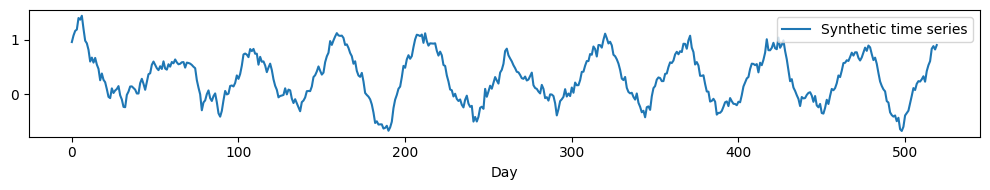

In [12]:
components = ['trend', 'fourrier', 'ar']
time_step_interval = 1
hyperparameters = {'trend': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': 0.9, 'process_error_var': 0.1**2},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([0.29, 0.00027, 0.5, 0.4, -0.0621]), \
          'var': np.diag([0.00531, 2.61E-12, 1e-12, 1e-12, 6.36E-05])}
num_steps = 10*52

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# ts = data_generator.generate_time_series()
data_generator.plot()


In [13]:
# datetime_save_path = 'data/synthetic/datetime.csv'
# observation_save_path = 'data/synthetic/observation.csv'

# with open(datetime_save_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     # writer.writerow(['date_time'])  # Write header
#     for dt in data_generator.time_series['timesteps']:
#         writer.writerow([dt])  # Write formatted datetime string

# with open(observation_save_path, 'w', newline='') as file:
#     writer = csv.writer(file)
#     for obs in data_generator.time_series['y']:
#         # write float
#         writer.writerow([obs])

# Kalman filter

In [14]:
anm_pos = 400
anm_mag = 0.0 # Medium anomaly: 0.01
detect_pos = []

In [15]:
# hyperparameters = {'trend': {'process_error_var': 0.0},
#                    'fourrier': {'period': 51, 'process_error_var': 0},
#                    'ar': {'phi': 0.86, 'process_error_var': 0.05**2},
#                    'observation': {'error': 1e-3}}
# x_init = {'mu': np.array([0.26, 0.0005, 0.45, 0.35, -0.0621]), \
#           'var': np.diag([1e-4, 1E-12, 1e-12, 1e-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

x_last_step = x_init
LL_mu, LT_mu, AR_mu = [], [], []
LL_var, LT_var, AR_var = [], [], []
y_pred_mus, y_pred_vars = [], []
total_reward = 0
rewards = []
for i in range(num_steps):
    if i in detect_pos:
        intervene = True
    else:
        intervene = False
    # Take action
    if intervene:
        x_last_step['var'][1,1] += 0.1

    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
    y_pred, x_pred, _ = kf.predict(x_last_step)
    x_updated, _, _ = kf.update(data_generator.time_series['y'][i])

    x_last_step = x_updated

    # Compute reward
    # if i >= 260 and i != 519:
    #     print(y_pred['mu'], y_pred['var'], data_generator.time_series['y'][i])
    reward = compute_LL_reward(y_pred, data_generator.time_series['y'][i])
    rewards.append(reward)

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())


In [16]:
# Print the mean and std of rewards
print(np.mean(rewards), np.std(rewards))
cost_intervention = (np.mean(rewards) + np.std(rewards))/(1-0.99)
print(cost_intervention)

0.9376952433595179 0.5852321926888775
152.2927436048394


Text(0, 0.5, 'AR')

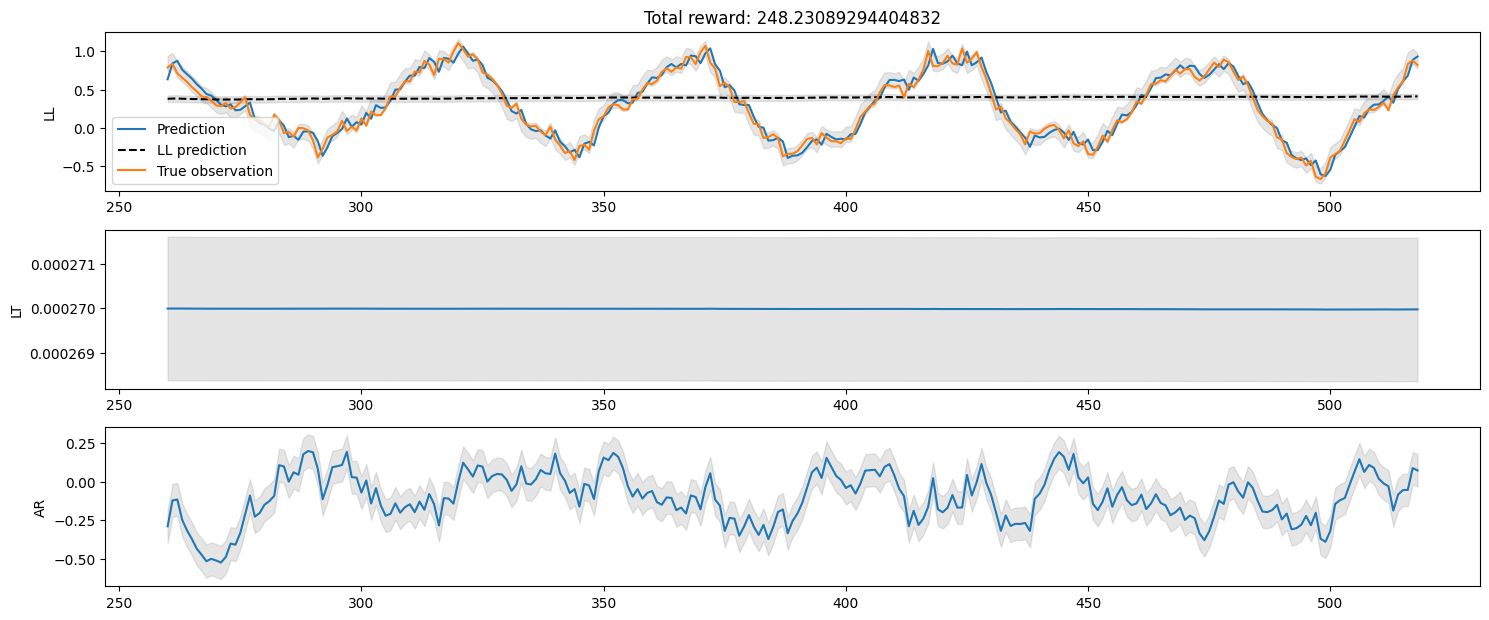

In [17]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

rewards = rewards[260:-1]

# Plot true observation and prediction, and LL
ax0.plot(data_generator.time_series['timesteps'][260:-1], y_pred_mus[260:-1], label='Prediction')
ax0.fill_between(data_generator.time_series['timesteps'][260:-1], np.array(y_pred_mus)[261:]-np.sqrt(y_pred_vars)[261:], np.array(y_pred_mus)[261:]+np.sqrt(y_pred_vars)[261:],color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'][260:-1], LL_mu[260:-1], 'k--', label='LL prediction')
ax0.fill_between(data_generator.time_series['timesteps'][260:-1], np.array(LL_mu)[260:-1]-np.sqrt(LL_var)[260:-1], np.array(LL_mu)[260:-1]+np.sqrt(LL_var)[260:-1],color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'][260:-1], data_generator.time_series['y'][260:-1], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
ax0.legend(loc='lower left')
ax0.set_ylabel('LL')
ax0.set_title('Total reward: {}'.format(np.sum(rewards)))

# Plot LT
ax1.plot(data_generator.time_series['timesteps'][260:-1], LT_mu[260:-1], label='LT prediction')
ax1.fill_between(data_generator.time_series['timesteps'][260:-1], np.array(LT_mu)[260:-1]-np.sqrt(LT_var)[260:-1], np.array(LT_mu)[260:-1]+np.sqrt(LT_var)[260:-1],color='gray', alpha=0.2)
ax1.set_ylabel('LT')

# Plot AR
ax2.plot(data_generator.time_series['timesteps'][260:-1], AR_mu[260:-1], label='AR prediction')
ax2.fill_between(data_generator.time_series['timesteps'][260:-1], np.array(AR_mu)[260:-1]-np.sqrt(AR_var)[260:-1], np.array(AR_mu)[260:-1]+np.sqrt(AR_var)[260:-1],color='gray', alpha=0.2)
ax2.set_ylabel('AR')

In [18]:
print(np.mean(rewards), np.std(rewards))

0.9584204360774067 0.534318177947731
